# Description

Notebook for generating medical claims figures and results (Section 6).

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import seaborn as sns
import sys

from scipy.stats import ttest_ind_from_stats
from tqdm import tqdm

In [2]:
# notebook magics
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
sys.path.append("../src/rdd-discovery/utils/")

# Load data

In [4]:
clinic_settings = ['breast_cancer', 'colon_cancer', 'diabetes']
clinic_dict = {}
data_dir = "../data/{}_running.parq"

for clinic in clinic_settings:
    df = pd.read_parquet(data_dir.format(clinic))
    clinic_dict[clinic] = df

# Point plot figure

In [5]:
blue = sns.color_palette()[0]
orange = sns.color_palette()[1]

/tmp/ipykernel_43237/3759474046.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merge_df = baseline_df.append(subgroup_df)
/tmp/ipykernel_43237/3759474046.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merge_df = baseline_df.append(subgroup_df)


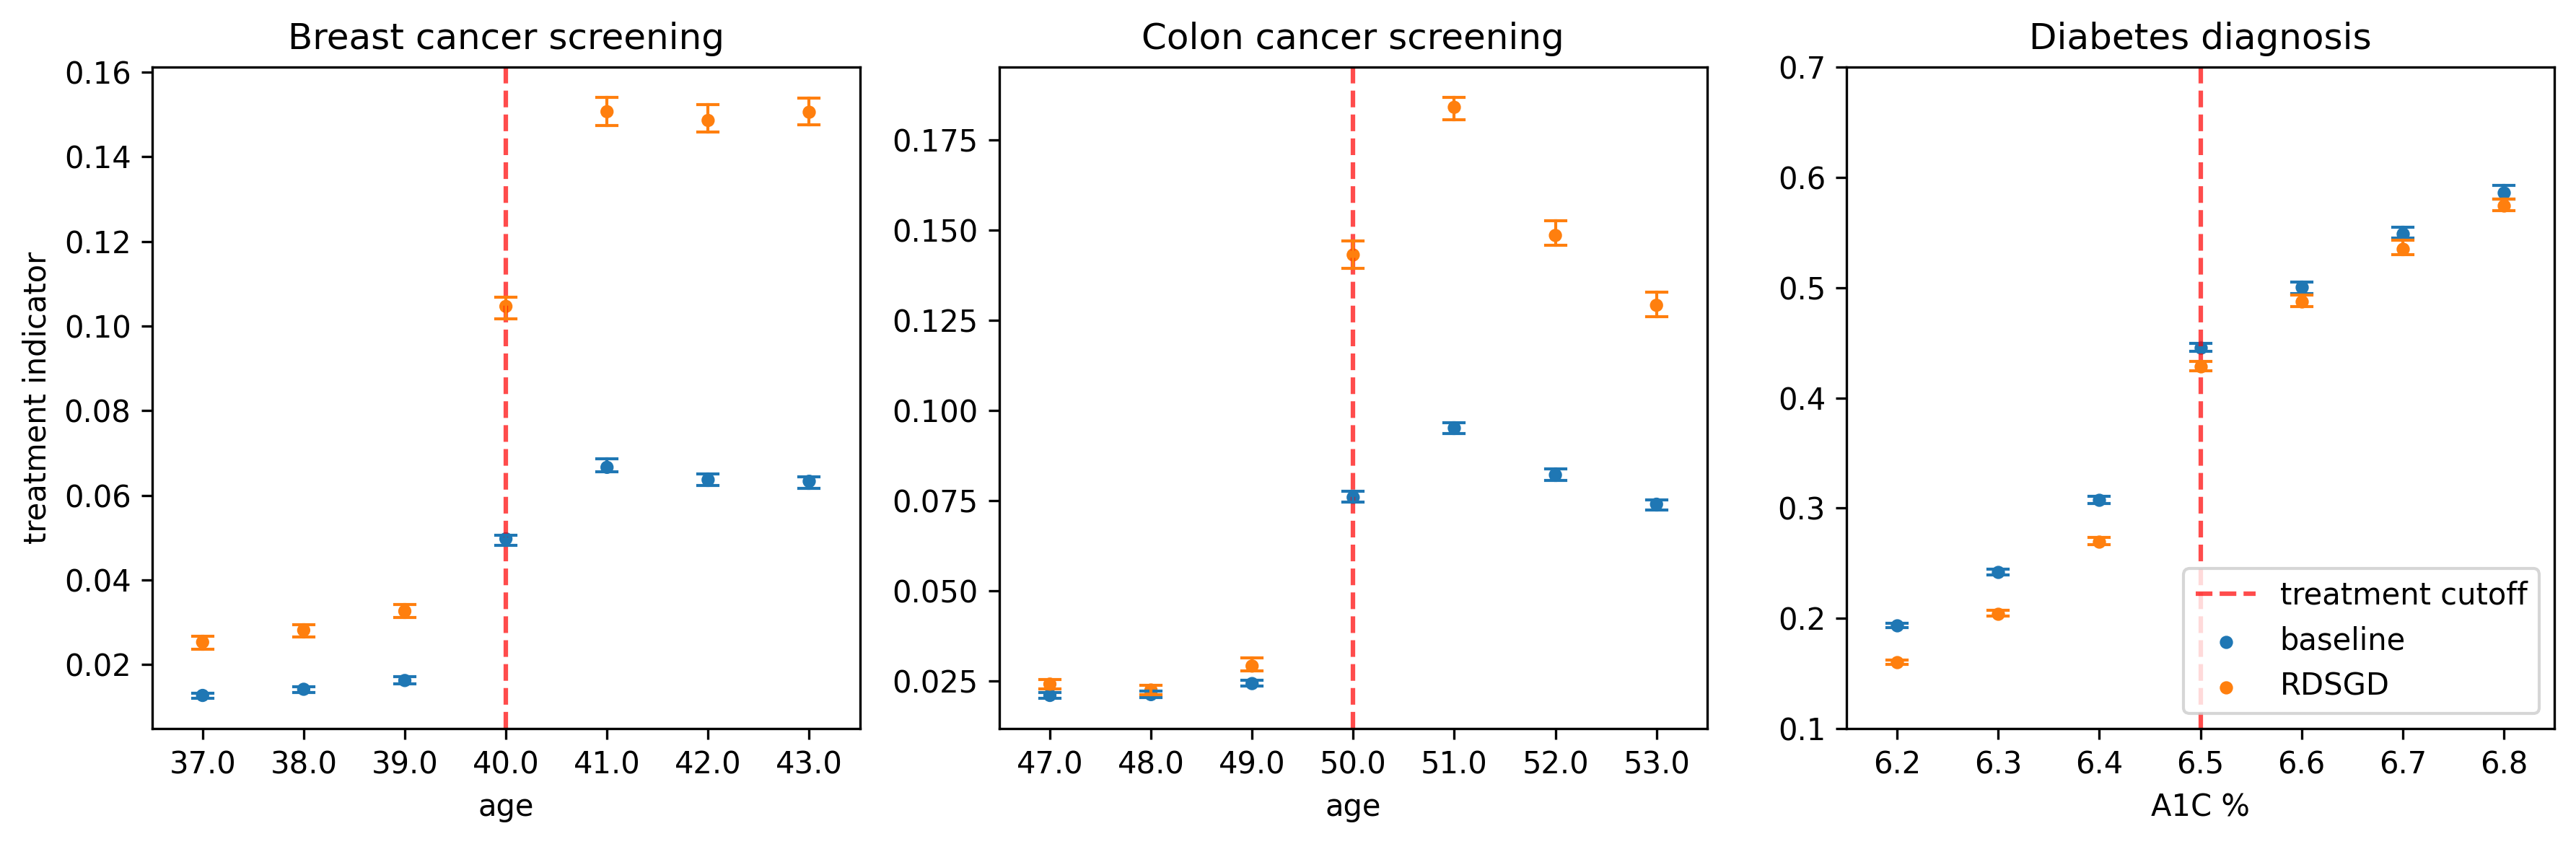

In [6]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(12,4), dpi=300)

point_plot_kwargs = dict(
    join=False,
    n_boot=50, 
    ci=95, 
    scale=0.5,
    errwidth=1, 
    capsize=0.2,
)


# breast cancer
bc_df = clinic_dict['breast_cancer']
#print(bc_df.columns)
ax1.axvline(x=3, ls='--', color='red', label="treatment cutoff", alpha=0.7)
ax1.set_title("Breast cancer screening")
sns.pointplot(data=bc_df, x='age', y='indicator', ax=ax1, color=blue, alpha=0.2, **point_plot_kwargs)
sns.pointplot(data=bc_df[bc_df['in_subgroup'] == 1], x='age', y='indicator', ax=ax1, color=orange, **point_plot_kwargs)
ax1.set_ylabel("treatment indicator")

# colon cancer
cc_df = clinic_dict['colon_cancer']

baseline_df = cc_df.copy()
baseline_df[" "] = 'baseline'
subgroup_df = cc_df[cc_df['in_subgroup'] == 1].copy()
subgroup_df[" "] = 'subgroup'
merge_df = baseline_df.append(subgroup_df)
#print(bc_df.columns)
ax2.axvline(x=3, ls='--', color='red', label="treatment cutoff", alpha=0.7)
ax2.set_title("Colon cancer screening")
#sns.pointplot(data=merge_df, x='age', y='indicator', ax=ax2, hue=" ", alpha=0.2, label="baseline", **point_plot_kwargs)
sns.pointplot(data=cc_df, x='age', y='indicator', ax=ax2, color=blue, alpha=0.2, label="baseline", **point_plot_kwargs)
sns.pointplot(data=cc_df[cc_df['in_subgroup'] == 1], x='age', y='indicator', ax=ax2, color=orange, label="RDSGD", **point_plot_kwargs)
ax2.set_ylabel("")

# diabetes
dm_df = clinic_dict['diabetes']
dm_df['lr_fmt'] = dm_df['lr_fmt'].round(1)

baseline_df = dm_df.copy()
baseline_df[" "] = 'baseline'
subgroup_df = dm_df[dm_df['in_subgroup'] == 1].copy()
subgroup_df[" "] = 'RDSGD'
merge_df = baseline_df.append(subgroup_df)

#print(bc_df.columns)
ax3.axvline(x=4, ls='--', color='red', label="treatment cutoff", alpha=0.7)
ax3.set_title("Diabetes diagnosis")
sns.pointplot(data=merge_df, x='lr_fmt', y='indicator', ax=ax3, hue=" ", alpha=0.2, label="baseline", **point_plot_kwargs)
#sns.pointplot(data=dm_df, x='lr_fmt', y='indicator', ax=ax3, color=blue, alpha=0.2, **point_plot_kwargs)
#sns.pointplot(data=dm_df[dm_df['in_subgroup'] == 1], x='lr_fmt', y='indicator', ax=ax3, color=orange, **point_plot_kwargs)
ax3.set_xlim(0.5, 7.5);
ax3.set_ylim(0.1, 0.7);
ax3.set_xlabel("A1C %");
ax3.legend(loc='lower right')
ax3.set_ylabel("")
#ax3.set_ylabel("treatment indicator");
fig.tight_layout()
plt.savefig("../figures/fig3_point_point.png", bbox_inches="tight")

# T-tests for TAU differences

## Load data

In [7]:
# note, original data from llr_results were removed to fit within file size limit
subgroups_dict = pickle.load(open("../data/claims_subgroups.dict", "rb"))

In [12]:
for med_setting, med_dict in subgroups_dict.items():
    #print(med_dict.keys())
    for key, d in med_dict.items(): 
        print(d.keys())
        print(d['net_benefit'])
        print(f"{med_setting}: {key}")
        print(d['llr_results'])
        

dict_keys(['mean', 'std', 'ci', 'ci_len', 'rule_path', 'llr_results', 'net_benefit'])
0.0
breast_cancer: baseline
                            OLS Estimation Summary                            
Dep. Variable:              indicator   R-squared:                      0.0138
Estimator:                        OLS   Adj. R-squared:                 0.0138
No. Observations:              657881   F-statistic:                 1.073e+04
Date:                Thu, Apr 14 2022   P-value (F-stat)                0.0000
Time:                        15:05:13   Distribution:                  chi2(3)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Intercept      0.

In [9]:
dm_bl = subgroups_dict['diabetes']['baseline']['llr_results']
dm_sub = subgroups_dict['diabetes']['subgroup']['llr_results']

In [10]:
cc_bl = subgroups_dict['colon_cancer']['baseline']['llr_results']
cc_sub = subgroups_dict['colon_cancer']['subgroup']['llr_results']

In [11]:
bc_bl = subgroups_dict['breast_cancer']['baseline']['llr_results']
bc_sub = subgroups_dict['breast_cancer']['subgroup']['llr_results']

In [12]:
ttest_ind_from_stats(dm_sub.params['z'], dm_sub.std_errors['z'], dm_sub.nobs,
                     dm_bl.params['z'], dm_bl.std_errors['z'], dm_bl.nobs,
                     equal_var=False)

Ttest_indResult(statistic=3394.497009222335, pvalue=0.0)

In [13]:
ttest_ind_from_stats(cc_sub.params['z'], cc_sub.std_errors['z'], cc_sub.nobs,
                     cc_bl.params['z'], cc_bl.std_errors['z'], cc_bl.nobs,
                     equal_var=False)

Ttest_indResult(statistic=13687.461941139063, pvalue=0.0)

In [14]:
ttest_ind_from_stats(bc_sub.params['z'], bc_sub.std_errors['z'], bc_sub.nobs,
                     bc_bl.params['z'], bc_bl.std_errors['z'], bc_bl.nobs,
                     equal_var=False)

Ttest_indResult(statistic=13125.751502916351, pvalue=0.0)